In [10]:
%matplotlib notebook

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
import custom_strategies
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd

custom_strategies.LIMIT_YEAR = 2015
reload()
# !pip install matplotlib-venn

In [11]:
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    related = state.related - state.find("s0").related
    for work in state.related:
        backward |= (set(strategy.ref[work]) & related)
        forward |= (set(strategy.rev_ref[work]) & related)
    return backward, forward

#busca("scopus", seed=["wohlin2014a", "briand2000a"], filter_function=lambda x: True)
#busca("scopus", filter_function=lambda x: False)

# Estratégias

## Estratégia 1 - Busca em todas Digital Libraries (DL)

In [12]:
print ("Total de estudos primários usados como Seed Set: ", len ([x for _, x in load_work_map_all_years() if x.category == "snowball"]))


Total de estudos primários usados como Seed Set:  51


In [13]:
print ("Lista de estudos primários usados como Seed Set:")
([x for _, x in load_work_map_all_years() if x.category == "snowball"])

Lista de estudos primários usados como Seed Set:


[Exploring the use of the cynefin framework to inform software development approach decisions,
 An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI),
 Application of GQM+ Strategies in a small software development unit,
 A cynefin based approach to process model tailoring and goal alignment,
 Aligning Organizations Through Measurement,
 A conceptual framework for SPI evaluation,
 The effects of gqm+strategies on organizational alignment,
 Experiences and insights from applying gqm+ strategies in a systems product development organisation,
 Development and Evaluation of Systems Engineering Strategies: An Assessment-Based Approach,
 A framework for systematic evaluation of process improvement priorities,
 Strategically balanced process adoption,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Aligning software projects with business objectiv

In [14]:
reload()
TOTAL = [x for _, x in load_work_map_all_years() if x.category == "snowball"]
filter_function = lambda x: x.category in ("snowball", "forward", "backward")


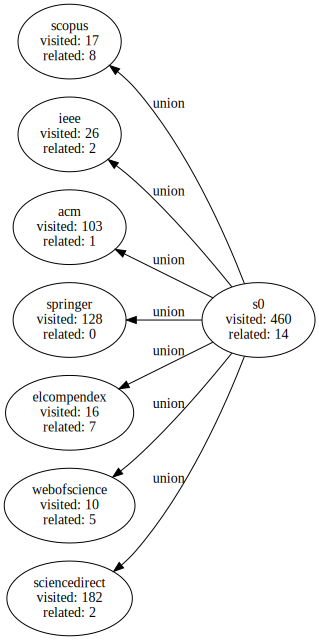

In [15]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl
        if union is None:
            union = strategy.initial.derive("union", name="s0")
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

strategy = busca_completa(["scopus", "ieee", "acm", "springer", "elcompendex", "webofscience", "sciencedirect"], filter_function)
#strategy.initial.find("acm")
strategy.initial



In [16]:
array = []

print ("--- Estratégia 1 (E1) ---")
name = "E1"
EP = (len (strategy.initial.related) / len (strategy.initial.visited))*100
print ("Precision: " + "%.1f" %EP +"%")
ER = (len (strategy.initial.related) / len (TOTAL))*100
print ("Recall: " + "%.1f" %ER +"%")
FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.1f" %FS +"%")

array.append((name, EP, ER, FS))

--- Estratégia 1 (E1) ---
Precision: 3.0%
Recall: 27.5%
F-Measure: 5.5%


## Estratégia 2 - Busca em todas Digital Libraries + Snowballing (Guideline - sfbu)

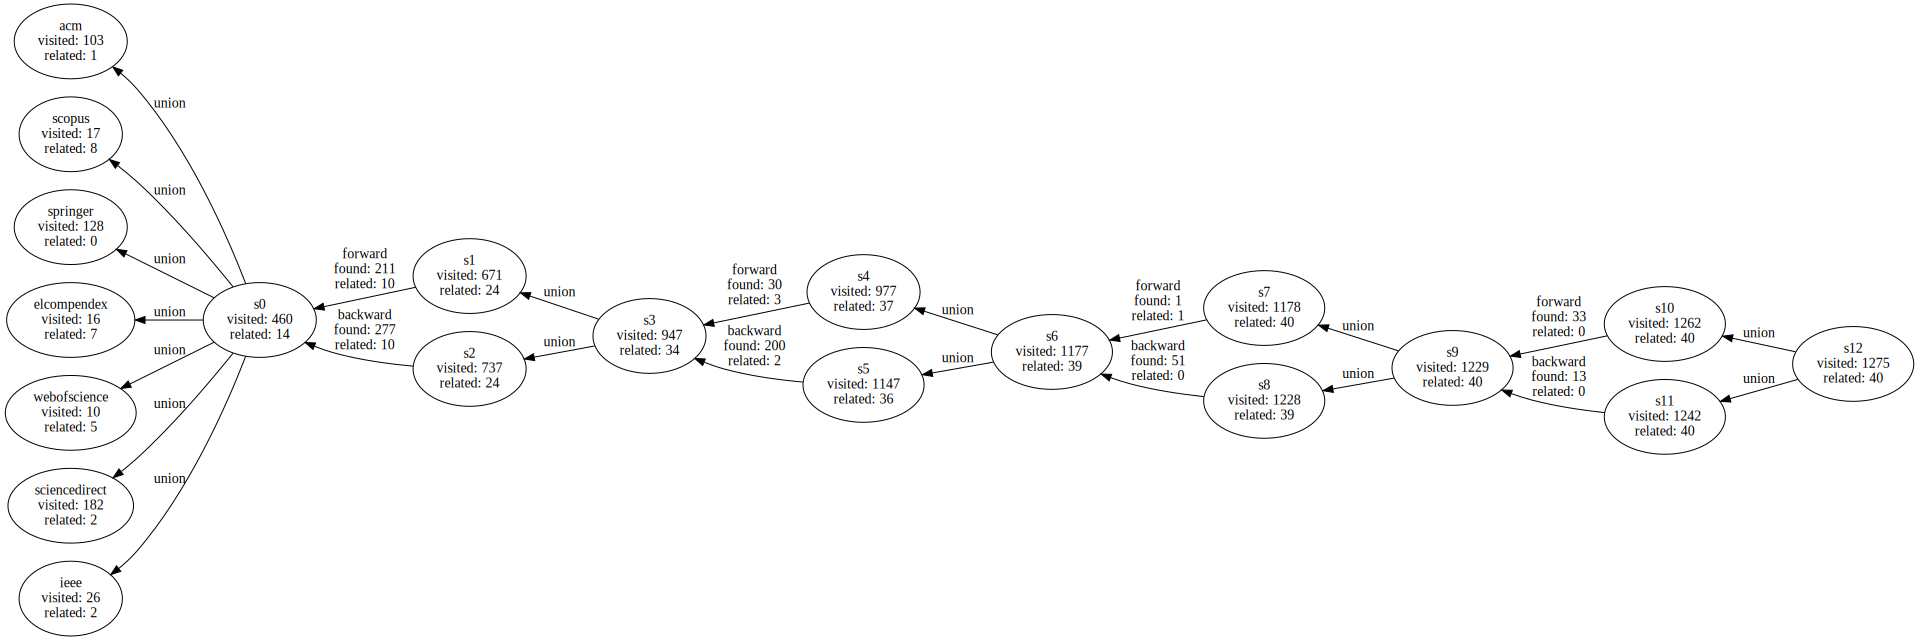

In [17]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["acm", "scopus", "springer", "elcompendex", "webofscience", "sciencedirect", "ieee"], filter_function)
#Strategy(*busca("acm","scopus", filter_function=filter_function))

state = strategy.sfbu()
#state = strategy.bbff()
#state = strategy.ffbb()
#state = strategy.s2ffbb2u()

state

In [18]:
def duplicados(strategy, state):
    encontrados = set()
    result = set()
    soma = 0
    related = state.related - state.find("s0").related
    for work in state.related:
        inter = encontrados & (set(strategy.ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "backward", inter @ metakey)
        inter = encontrados & (set(strategy.rev_ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "forward", inter @ metakey)
    return soma

<IPython.core.display.Javascript object>


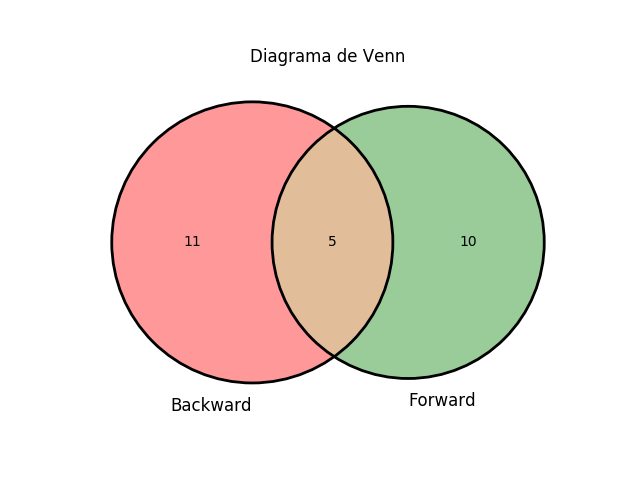

In [19]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title('Diagrama de Venn')
plt.show()

In [29]:
#Backward - Execução de backward em sets[0]
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)

Backward ['murugappan2003a', 'mccoy1998a', 'liu2006a', 'münch2013c', 'kowalczyk2010a', 'münch2013a', 'mandić2010d', 'trienekens2009a', 'basili2007a', 'martins2007b', 'becker2008b', 'liu2005a', 'debou2000a', 'basili2007b', 'mandić2010a', 'trendowicz2011a']
Forward ['wang2005a', 'münch2013c', 'petersen2015a', 'trendowicz2014a', 'armbrust2010b', 'becker2008b', 'mandić2010a', 'stallinger2013a', 'trendowicz2011a', 'cocozza2014a', 'mcloughlin2010a', 'unterkalmsteiner2014a', 'mandić2010d', 'karlström2002a', 'armbrust2010a']


In [21]:
strategy.initial is state.find("s0")

True

In [22]:
E2P = (len (strategy.initial.related) / len (strategy.initial.visited))*100

print ("--Precision--")
print ("Busca: %.1f%%" % E2P)

E2PS = (len(state.related - state.find("s0").related) / len(state.visited - state.find("s0").visited))*100

print ("Snowballing: %.2f%%" % E2PS)

print("- Forward - iteração 1: %.2f%%" % ((len (state.find("s1").delta_related) / len (state.find("s1").delta_visited))*100))

print("- Backward - iteração 1: %.2f%%" % ((len (state.find("s2").delta_related) / len (state.find("s2").delta_visited))*100))

print("Precision E2 (Busca + Snowballing): %.1f%%" % ((len(state.related) / len(state.visited))*100))


print ("\n--- Estratégia 2 (E2) ---")
name = "E2"
EP = (len (state.related) / len (state.visited))*100
print ("Precision: " + "%.1f" %EP +"%")
ER = (len (state.related) / len (TOTAL))*100
print ("Recall: " + "%.1f" %ER +"%")
FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.1f" %FS +"%")

array.append((name, EP, ER, FS))

--Precision--
Busca: 3.0%
Snowballing: 3.19%
- Forward - iteração 1: 4.74%
- Backward - iteração 1: 3.61%
Precision E2 (Busca + Snowballing): 3.1%

--- Estratégia 2 (E2) ---
Precision: 3.1%
Recall: 78.4%
F-Measure: 6.0%


In [23]:
from collections import deque
def precision_recall(state, total, stop=""):
    # Precisao 0 quando nao visita nada
    array = [[
        "state", "precision", "recall", "operation", 
        "related", "visited", "delta_related", "delta_visited",
        "accumulated_precision", "accumulated_recall",
    ]]
    stack = deque([state])
    visited = {id(state)}
    while stack:
        current = stack.pop()
        try:
            accumulated_precision = len(current.related) / len(current.visited)
            precision = len(current.delta_related) / len(current.delta_visited)
        except ZeroDivisionError:
            precision = 0.0
            
        array.append([
            current.name,
            precision,
            len(current.delta_related) / len(total),
            current.previous[1] if current.previous else "-",
            len(current.related),
            len(current.visited),
            len(current.delta_related),
            len(current.delta_visited),
            accumulated_precision,
            len(current.related) / len(total),
        ])
        if current.name == stop:
            break
        if current.previous:              
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.appendleft(previous)
    return array

In [24]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
df

20,state,precision,recall,operation,related,visited,delta_related,delta_visited,accumulated_precision,accumulated_recall
0,ieee,0.0769231,0.0392157,-,2,26,2,26,0.0769231,0.0392157
1,sciencedirect,0.010989,0.0392157,-,2,182,2,182,0.010989,0.0392157
2,webofscience,0.5,0.0980392,-,5,10,5,10,0.5,0.0980392
3,elcompendex,0.4375,0.137255,-,7,16,7,16,0.4375,0.137255
4,springer,0,0,-,0,128,0,128,0,0
5,scopus,0.470588,0.156863,-,8,17,8,17,0.470588,0.156863
6,acm,0.00970874,0.0196078,-,1,103,1,103,0.00970874,0.0196078
7,s0,0,0,union,14,460,0,0,0.0304348,0.27451
8,s2,0.0361011,0.196078,backward,24,737,10,277,0.0325645,0.470588
9,s1,0.0473934,0.196078,forward,24,671,10,211,0.0357675,0.470588


<IPython.core.display.Javascript object>


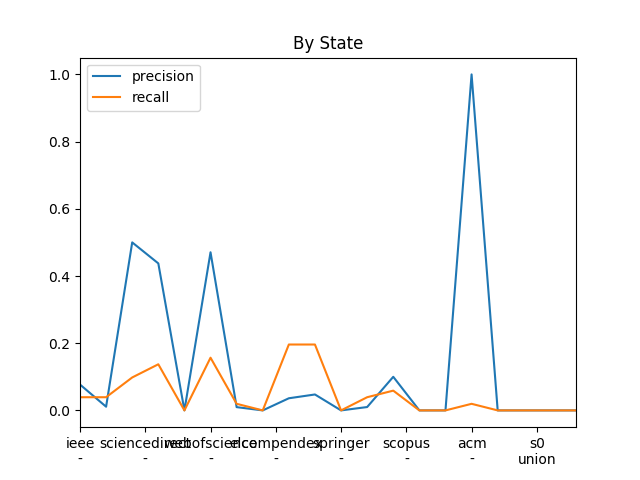

In [25]:
fig = plt.figure()
df['precision'].plot(legend=True)
df['recall'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("By State");

<IPython.core.display.Javascript object>


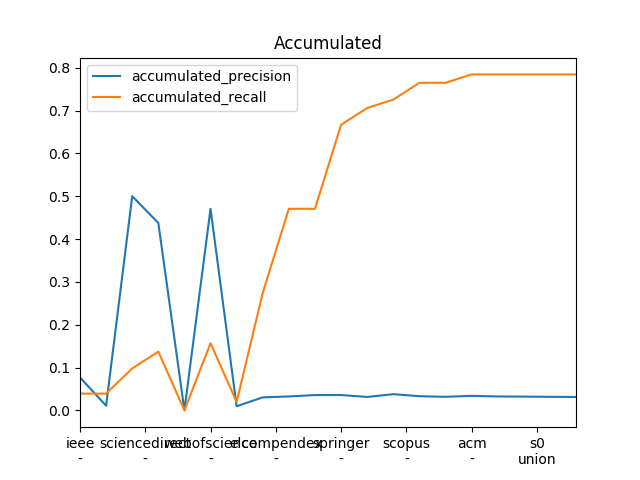

In [26]:
fig = plt.figure()
df['accumulated_precision'].plot(legend=True)
df['accumulated_recall'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("Accumulated");

## Estratégia 3 - Busca Informal (Google Scholar) + Snowballing (Guideline - sfbu)

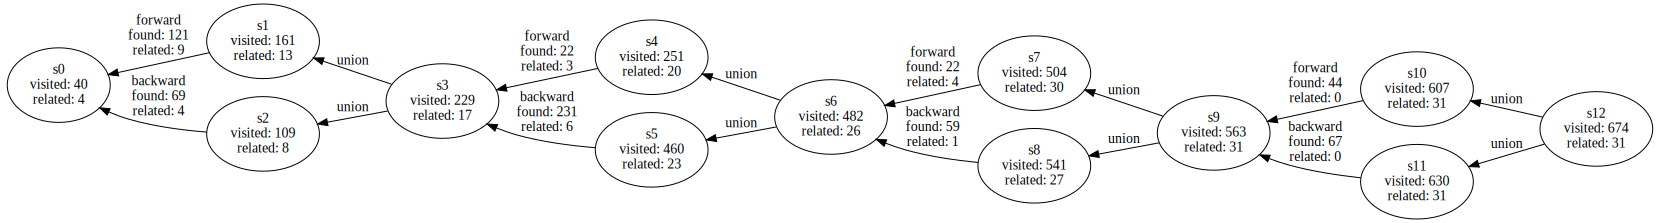

In [30]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs", filter_function=filter_function))
state = strategy.sfbu()
state

In [31]:
print ("--- Estratégia 3 (E3) ---")
name = "E3"
EP = (len (state.related) / len (state.visited))*100
print ("Precision: " + "%.1f" %EP +"%")
ER = (len (state.related) / len (TOTAL))*100
print ("Recall: " + "%.1f" %ER +"%")
FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.1f" %FS +"%")

array.append((name, EP, ER, FS))

--- Estratégia 3 (E3) ---
Precision: 4.6%
Recall: 60.8%
F-Measure: 8.6%



## Estratégia 4 - Busca em Scopus + Snowballing (Guideline - sfbu)

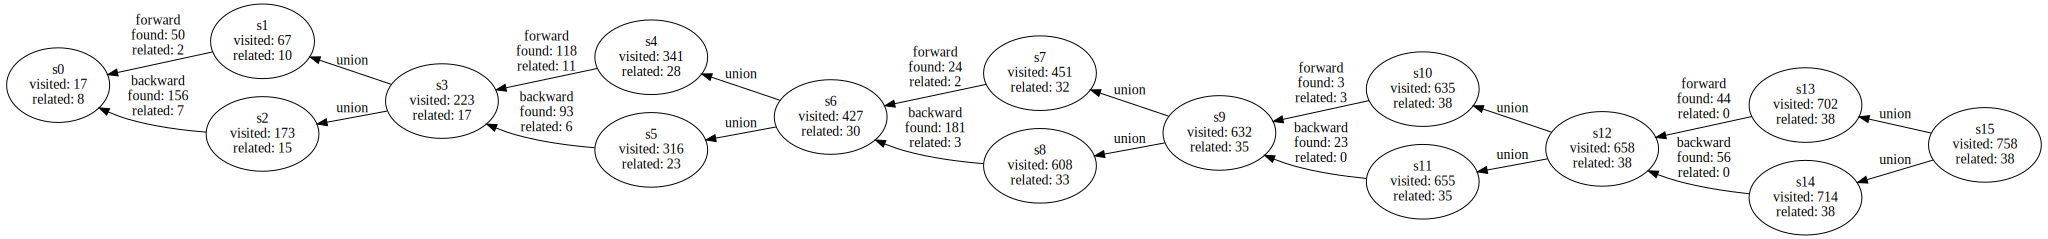

In [32]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

#from copy import copy
#strategy.initial.visited = copy(strategy.initial.related)
state = strategy.sfbu()
state

In [33]:
print ("--- Estratégia 4 (E4) ---")
name = "E4"
EP = (len (state.related) / len (state.visited))*100
print ("Precision: " + "%.1f" %EP +"%")
ER = (len (state.related) / len (TOTAL))*100
print ("Recall: " + "%.1f" %ER +"%")
FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.1f" %FS +"%")

array.append((name, EP, ER, FS))

--- Estratégia 4 (E4) ---
Precision: 5.0%
Recall: 74.5%
F-Measure: 9.4%


## Estratégia 5 - Busca em Scopus + Snowballing (Short Paper - s2ffbb2u)

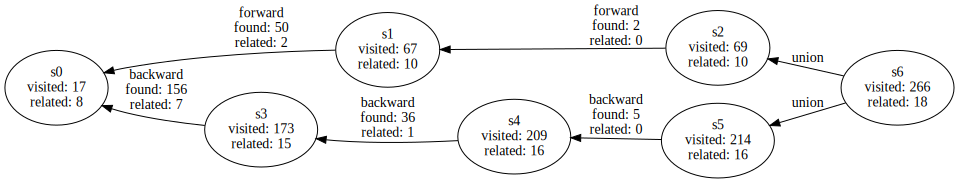

In [34]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.s2bbff2u()
state

In [35]:
print ("--- Estratégia 5 (E5) ---")
name = "E5"
EP = (len (state.related) / len (state.visited))*100
print ("Precision: " + "%.1f" %EP +"%")
ER = (len (state.related) / len (TOTAL))*100
print ("Recall: " + "%.1f" %ER +"%")
FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.1f" %FS +"%")

array.append((name, EP, ER, FS))

--- Estratégia 5 (E5) ---
Precision: 6.8%
Recall: 35.3%
F-Measure: 11.4%


## Estratégia 6 - Busca em Scopus + Snowballing (JF - bbff)

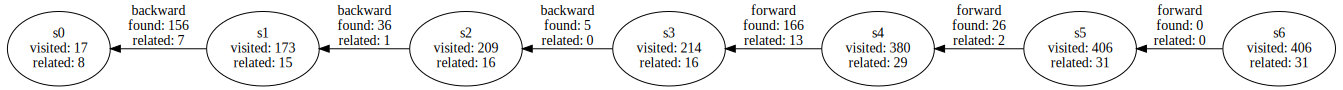

In [36]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.bbff()
state

In [37]:
print ("--- Estratégia 6 (E6) ---")
name = "E6"
EP = (len (state.related) / len (state.visited))*100
print ("Precision: " + "%.1f" %EP +"%")
ER = (len (state.related) / len (TOTAL))*100
print ("Recall: " + "%.1f" %ER +"%")
FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.1f" %FS +"%")

array.append((name, EP, ER, FS))

--- Estratégia 6 (E6) ---
Precision: 7.6%
Recall: 60.8%
F-Measure: 13.6%


## Estratégia 7 - Busca em Scopus + Snowballing (JF - ffbb)

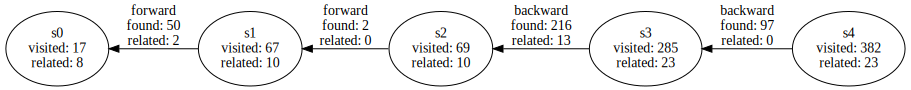

In [38]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.ffbb()
state

In [39]:
print ("--- Estratégia 7 (E7) ---")
name = "E7"
EP = (len (state.related) / len (state.visited))*100
print ("Precision: " + "%.1f" %EP +"%")
ER = (len (state.related) / len (TOTAL))*100
print ("Recall: " + "%.1f" %ER +"%")
FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.1f" %FS +"%")

array.append((name, EP, ER, FS))

--- Estratégia 7 (E7) ---
Precision: 6.0%
Recall: 45.1%
F-Measure: 10.6%


# Análise das Estratégias

In [40]:
%matplotlib notebook
import pandas as pd

In [41]:
df = pd.DataFrame (array,columns = ['Estratégia','Precision','Recall','F-Measure'])
df.index = df['Estratégia']
df


,Estratégia,Precision,Recall,F-Measure
Estratégia,,,,
E1,E1,3.043478,27.450980,5.479452
E2,E2,3.137255,78.431373,6.033183
E3,E3,4.599407,60.784314,8.551724
E3,E3,4.599407,60.784314,8.551724
E4,E4,5.013193,74.509804,9.394314
E5,E5,6.766917,35.294118,11.356467
E6,E6,7.635468,60.784314,13.566740
E7,E7,6.020942,45.098039,10.623557


<IPython.core.display.Javascript object>


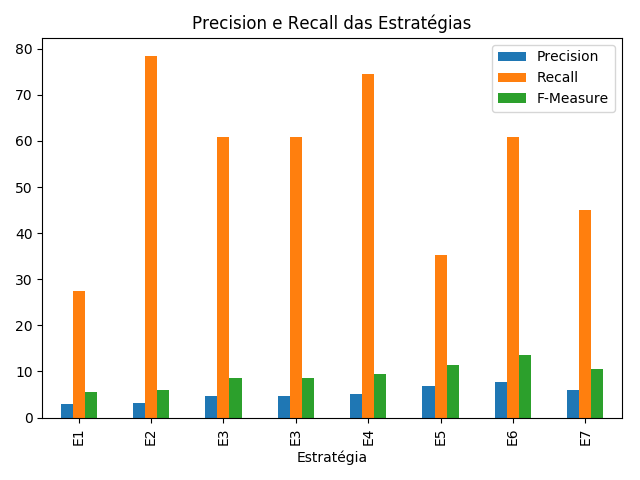

In [42]:
import matplotlib.pyplot as plt
ax = df.plot.bar(title ="Precision e Recall das Estratégias")
plt.tight_layout()


In [ ]:
df